Clean notebook for modeling

In [87]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from tensorflow_addons.metrics import RSquare
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU, LSTM, Activation, BatchNormalization,LeakyReLU
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

In [40]:
df = pd.read_csv('../martijn/martijn-nsrdb.csv')

In [41]:
features = ['Wind Speed', 'Wind Direction', 'Dew Point', 'Pressure', 'Relative Humidity', 'Temperature', 'Solar Zenith Angle']

cloudtypes = to_categorical(df['Cloud Type'])

month = to_categorical(df['Month'])

hour = to_categorical(df['Hour'])

In [42]:
stacked_data = np.hstack([df[features].values, df[['GHI']].values])

# Scale
ss = StandardScaler()
stacked_sc = ss.fit_transform(stacked_data)
stacked_tot = np.hstack([stacked_sc[:,:-1], cloudtypes[:,:], month[:,:], hour[:,:], stacked_sc[:,-1:]])


In [43]:
# split a multivariate sequence into samples
def split_sequences(data_in, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(data_in.shape[0]):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
        # check if we are beyond the dataset
        if out_end_ix > data_in.shape[0]:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = data_in[i:end_ix, :-1], data_in[end_ix-1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# choose a number of time steps #change this accordingly
n_steps_in, n_steps_out = 192, 24
# covert into input/output
X, y = split_sequences(stacked_tot, n_steps_in, n_steps_out)
nr_features = X.shape[2]

In [100]:
split_point = 1400 * 48
a = 1
train_X , train_y = X[:split_point, :] , y[:split_point, :]
test_X , test_y = X[split_point:, :] , y[split_point:, :]

train_X.shape, train_y.shape, test_X.shape, test_y.shape

((67200, 192, 54), (67200, 24), (20282, 192, 54), (20282, 24))

In [125]:
###THIS MODEL WORKS

#optimizer learning rate
opt = Nadam(learning_rate=0.0005)
es = EarlyStopping(patience=5)
# define model
model = Sequential()
#model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(GRU(32, activation='relu', return_sequences=True, input_shape=(n_steps_in, nr_features)))
model.add(Dropout(0.20))
model.add(GRU(32, activation='relu', kernel_regularizer=l2(0.05)))
#model.add(BatchNormalization())
model.add(Dense(n_steps_out))
model.add(Activation('linear'))
model.compile(loss='mse' , optimizer=opt , metrics=[RSquare()])

In [127]:
###Test alternatives

#optimizer learning rate
opt = Nadam(learning_rate=0.0005)
es = EarlyStopping(patience=5)
# define model
model = Sequential()
model.add(BatchNormalization())
model.add(Dropout(0.35))
model.add(GRU(64, activation='relu', return_sequences=True, input_shape=(n_steps_in, nr_features)))
model.add(Dropout(0.35))
model.add(GRU(32, activation='relu',  kernel_regularizer=l2(0.05)))

model.add(BatchNormalization())
model.add(Dense(n_steps_out))
model.add(Activation('linear'))
model.compile(loss='mse' , optimizer=opt , metrics=[RSquare()])

In [ ]:
# Fit network
history = model.fit(train_X , train_y , batch_size=200, epochs=90, verbose=1 ,validation_data=(test_X, test_y) ,shuffle=False, callbacks=[es])

Epoch 1/90
336/336 [==============================] - 61s 176ms/step - loss: 1.9839 - r_square: 0.5105 - val_loss: 0.7111 - val_r_square: 0.5600
Epoch 2/90
336/336 [==============================] - 57s 170ms/step - loss: 0.3052 - r_square: 0.8003 - val_loss: 0.4287 - val_r_square: 0.5640
Epoch 3/90
336/336 [==============================] - 57s 169ms/step - loss: 0.1966 - r_square: 0.8194 - val_loss: 0.4504 - val_r_square: 0.5255
Epoch 4/90
336/336 [==============================] - 58s 171ms/step - loss: 0.1856 - r_square: 0.8248 - val_loss: 0.4194 - val_r_square: 0.5568
Epoch 5/90
336/336 [==============================] - 59s 177ms/step - loss: 0.1810 - r_square: 0.8284 - val_loss: 0.4321 - val_r_square: 0.5426
Epoch 6/90
336/336 [==============================] - 62s 185ms/step - loss: 0.1782 - r_square: 0.8308 - val_loss: 0.4078 - val_r_square: 0.5684
Epoch 7/90
336/336 [==============================] - 63s 187ms/step - loss: 0.1773 - r_square: 0.8317 - val_loss: 0.4220 - val_r_

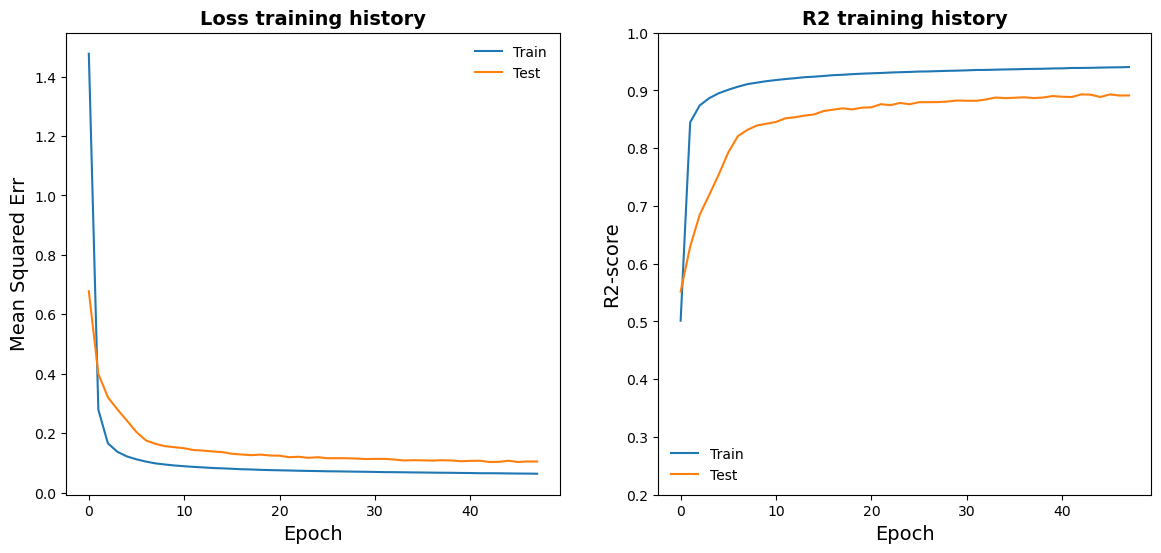

In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.plot(history.history['loss'], label='Train')
ax1.plot(history.history['val_loss'], label='Test')
ax1.legend(frameon=False)
#ax1.set_ylim(0, 25000)
ax1.set_ylabel('Mean Squared Err', fontsize=14)

ax1.set_xlabel('Epoch', fontsize=14)

ax1.set_title('Loss training history', fontweight='bold', fontsize=14)
ax2.plot(history.history['r_square'], label='Train')
ax2.plot(history.history['val_r_square'], label='Test')
ax2.legend(frameon=False)
ax2.set_title('R2 training history',  fontweight='bold', fontsize=14)
ax2.set_ylim(0.2, 1)
ax2.set_ylabel('R2-score', fontsize=14)
ax2.set_xlabel('Epoch', fontsize=14)
#fig.savefig('RNN_first_martijn.png', dpi=300)
plt.show()

In [59]:
preds_train = model.predict(train_X)

2100/2100 [==============================] - 35s 16ms/step


In [60]:
preds_test = model.predict(test_X)

634/634 [==============================] - 10s 16ms/step


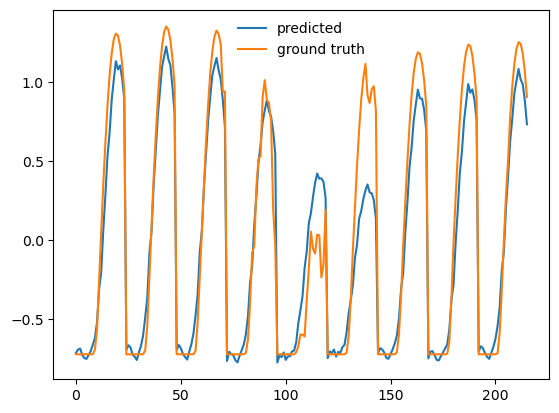

In [66]:
preds_l, test_l = [], []
x = 5
for i in range(11, 20):
    preds_l += list(preds_test[i*48+x,:])
    test_l += list(test_y[i*48+x,:])
plt.plot(preds_l, label='predicted')
plt.plot(test_l, label='ground truth')
plt.legend(frameon=False)